# Convection-diffusion in a rectangular cavity

### Problem

Solve the time dependent convection-diffusion equation

$$ \frac{\partial T}{\partial t} = - \upsilon \frac{\partial T}{\partial x} + \kappa \left( \frac{\partial^{2} T}{\partial x^{2}} + \frac{\partial^{2} T}{\partial y^{2}} \right) $$

with the Alternating Direction Implicity method, and iterate it in time until it reaches a steady state $\frac{\partial T}{\partial t} = 0 $.

By using forward differences for the time derivative, central differences for the spatial derivatives, use the Alternating Direction Implicit method to develop a semi-implicit algorithm in two spatial directions. Obtain the temperature distribution given the following boundary conditions: 

> $T = 65$ at $x = 0$

> $T = 25$ at $x = 30 \frac{\kappa}{\upsilon}$

> $T = 25$ at $y = 10 \frac{\kappa}{\upsilon}$

> $\frac{\partial T}{\partial y} = 0$ at $y = 0$

Note, you can use $\kappa = \upsilon = 1$

### ADI method for the convection-diffusion equation ###

In an upcoming homework, you will solve the convection-diffusion equation for some temperature distribution $T(x,y,t)$, the evolution of which is governed by the equation,

$$
\frac{\partial T}{\partial t} = - v \frac{\partial T}{\partial x} +D \left( \frac{\partial^{2} T}{\partial x^{2}} + \frac{\partial^{2} T}{\partial y^{2}} \right)
$$

We discretize $x = (i − 1) h, i = 1, \dots , N$, $y = (j − 1) h, j = 1, \ldots , M$, and $t = n \Delta t$, $n = 0, 1, \ldots$. We then introduce the ADI method described above,

$$
\frac{T_{ij}^{n+1/2} - T_{ij}^{n}}{\Delta t/2} = - \frac{v}{2h} \left( T_{i+1\ j}^{n+1/2} - T_{i-1 \ j}^{n+1/2} \right) + \frac{D}{h^{2}} \left( T_{i+1 \ j}^{n+1/2}-2T_{ij}^{n+1/2}+T_{i-1 \ j}^{n+1/2} + T_{i \ j+1}^{n}-2T_{ij}^{n}+T_{i \ j-1}^{n} \right)
$$

$$
\frac{T_{ij}^{n+1} - T_{ij}^{n+1/2}}{\Delta t/2} = \frac{v}{2h} \left( T_{i+1\ j}^{n+1/2} - T_{i-1 \ j}^{n+1/2} \right) + \frac{D}{h^{2}} \left( T_{i+1 \ j}^{n+1/2}-2T_{ij}^{n+1/2}+T_{i-1 \ j}^{n+1/2} + T_{i \ j+1}^{n+1}-2T_{ij}^{n+1}+T_{i \ j-1}^{n+1} \right)
$$

These two systems of equations can be re written in the form appropriate for a matrix solution as,

$$
{\rm First \; half \; step:} \quad (\beta - \alpha) T_{i+1 \ j}^{n+1/2} + (1 + 2 \alpha) T_{ij}^{n+1/2} -(\beta+\alpha) T_{i-1 \ j}^{n+1/2} = \alpha T_{i\ j+1}^{n} + (1 - 2 \alpha) T_{ij}^{n} + \alpha T_{i \ j-1}^{n}.
$$

$$
{\rm Second \; half \; step:} \quad - \alpha T_{i \ j+1}^{n+1} + (1 + 2 \alpha) T_{ij}^{n+1} -\alpha T_{i \ j-1}^{n+1} = (\alpha - \beta) T_{i+1\ j}^{n+1/2} + (1 - 2 \alpha) T_{ij}^{n+1/2} + (\alpha + \beta) T_{i-1 \ j}^{n+1/2}.
$$

with $\alpha = D \Delta t/(2h^{2})$ and $\beta = v \Delta t/4h$.

Both systems can be written in tridiagonal form by transforming the matrix $T_{ij}$ into a one dimensional array $u_{l}$ of length $L = M \times N$, basically wrapping around the matrix in a column wise form: $l = (j-1)N + i$. For the first half step, One has,

$$
\begin{pmatrix}
b_{1} & c_{1} & & & & \\
a_{2} & b_{2} & c_{2} & & & \\
 & & \cdots & & & \\
 & & & a_{L-1} & b_{L-1} & c_{L-1} \\
 & & & & a_{L} & b_{L} 
\end{pmatrix}
\begin{pmatrix}
u_{1} \\ u_{2} \\ \ldots \\ u_{L-1} \\ u_{L}
\end{pmatrix}
=
\begin{pmatrix}
d_{1} \\ d_{2} \\ \ldots \\ d_{L-1} \\ d_{L}
\end{pmatrix}
$$

with $a_{l} = - (\alpha + \beta)$, $b_{l} = 1 + 2 \alpha$, $c_{l} = \beta - \alpha$, and $d_{l}=\alpha T_{i \ j+1}^{n} + (1-2 \alpha) T_{ij}^{n} + \alpha T_{i \ j-1}^{n}$.

The second half step is slightly different, but the only change that is needed is to modify the coefficients of the matrix.

In the homework, we will address the issue of transfering the boundary conditions on $T$ or its normal derivative to $u$. We note here that the inverse to the transformation given from $(i,j)$ to $l$, is,

$$
{\rm Forward:} \quad l = (j-1)N + i. \quad {\rm Inverse:} \quad i = 1+ {\rm INT}\left( \frac{l-1}{N} \right), \;\; j = 1 + (l-1){\rm MOD}(N)
$$

For the second half step, one would have

$$
{\rm Forward:} \quad m = (i-1)M + j. \quad {\rm Inverse:} \quad j = 1 + {\rm INT}\left( \frac{m-1}{M} \right) \quad\quad i = 1 + (m-1){\rm MOD}(M).
$$

In summary, for each half step one solves the augmented system (of size $N \times M$) for the array $u$, which is just a tridiagonal system of equations for this particular partial differential equation. Iteration over $n$ would then yield the temporal evolution of the temperature field in this model.

In [1]:
import os
import re
import time
import imageio
import warnings
import numpy as np
import seaborn as sns
from numba import jit, njit
from scipy import sparse
import matplotlib as mpl
from matplotlib import cm
from numba import jit, njit
import matplotlib.pyplot as plt
from matplotlib import animation, rc
# from scipy.sparse import linalg as ln
import numpy.linalg as ln
from IPython.display import HTML, Image
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

# sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
# %config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)

In [2]:
# Setup
h = 1
k = 1
υ = 1

Δt = 0.02
α = k*Δt/(2*h**2)
β = υ*Δt/(4*h)

Nt = 10000
t = np.arange(0,Nt*Δt, Δt)
print(α, β)

0.01 0.005


In [3]:
# Initial T (Boundary Conds)
def imposeBCs(T):
    T[N-1,:] = 0
    T[:,M-1] = 25
    T[0,:] = 40
    T[0:10,10] = 60
    
    T[:,0] = T[:,1]
    return T

N = 50 
M = 20 
T = np.zeros((N, M))
T = imposeBCs(T)

U_T = np.zeros((Nt, N, M))
U_T[0] = T

In [4]:
nx = U_T.shape[2]
ny = U_T.shape[1]
x = range(nx)
y = range(ny)
X, Y = np.meshgrid(x,y)

In [5]:
def plot_iteration(i, save_fig=False, OUTPUT_DIR="./temperature_plots/"):
    print("\r Plot Iteration {}".format(i), end="")
    fig = plt.figure(figsize=(16,15))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, U_T[i], cmap=cm.coolwarm, linewidth=0.5)#, antialiased=False)
    ax.view_init(10,70)
    plt.title("Temperature Distribution: Iteration {}".format(i), fontsize=20)
    plt.xlabel("y", fontsize=18)
    plt.ylabel("x", fontsize=18)
    ax.set_zlim([0,70])
    if save_fig:
        plt.savefig(OUTPUT_DIR +'plot_{}.png'.format(i))
        plt.close()
    else:
        plt.show()

 Plot Iteration 0

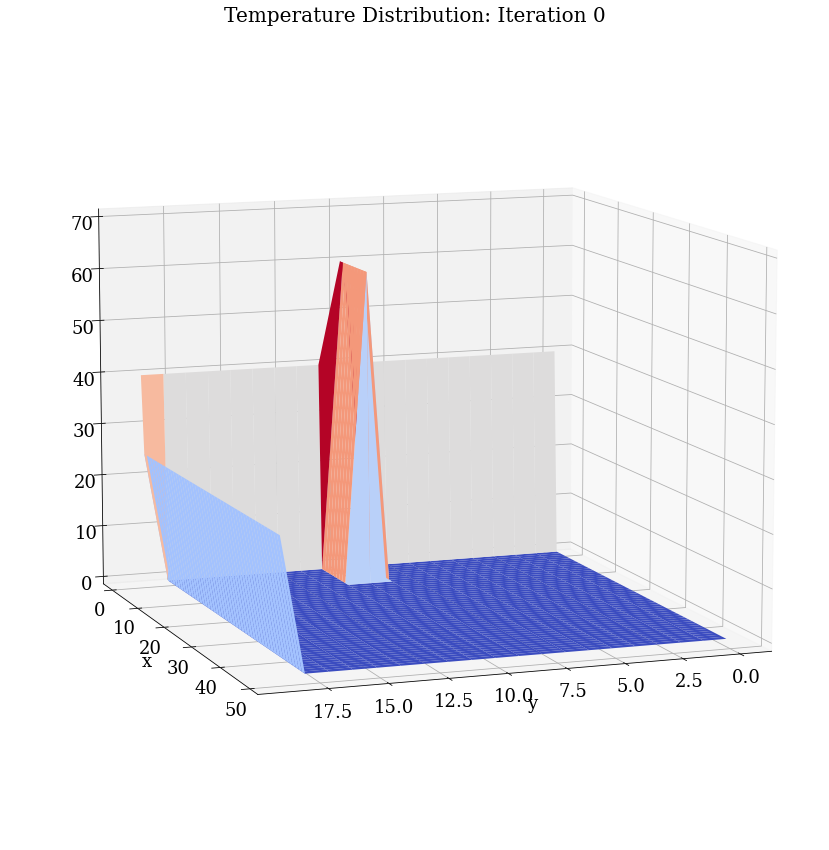

In [6]:
plot_iteration(i=0)

In [7]:
a_l = -(α + β)
b_l = 1 + 2*α
c_l = β - α

a_m = -α 
b_m = 1 + 2*α
c_m = -α

M1 = sparse.diags([b_l*np.ones(M*N), c_l*np.ones(M*N-1), a_l*np.ones(M*N-1)], [0, 1, -1])
M2 = sparse.diags([b_m*np.ones(M*N), c_m*np.ones(M*N-1), a_m*np.ones(M*N-1)], [0, 1, -1])
M1 = M1.toarray()
M2 = M2.toarray()

In [10]:
@njit 
def inverse_one(l,K):
    i = int(l/K)
    j = l % K
    return i, j


@njit 
def inverse_two(m,K):
    j = int(m/K)
    i = m % K
    return i, j


@njit 
def concatenate_one(T, d_l):    
    for l in range(N*M):
        i, j = inverse_one(l,M)
        # This is ugly code but it works 
        if j == 0:
            j = 1
        if j == M-1:
            # T[i,j+1] (out of bounds) = T[i,j], d_l simplifies to ...
            d_l[l] = (1-α)*T[i, j] + α*T[i,j-1]
        else:
            d_l[l] = α*T[i,j+1] + (1-2*α)*T[i,j] + α*T[i,j-1]
    return d_l


@njit
def concatenate_two(T1, d_m):
    for m in range(N*M):   
        i, j = inverse_two(m,N)
        if i == 0:
            # i-1 -> i
            d_m[m] = (α-β)*T1[i+1,j] + (1-2*α)*T1[i,j] + (α+β)*T1[i,j]
        if i == N-1:
            # i+1 -> i
            d_m[m] = (α-β)*T1[i,j] + (1-2*α)*T1[i,j] + (α+β)*T1[i-1,j]
        else:
            d_m[m] = (α-β)*T1[i+1,j] + (1-2*α)*T1[i,j] + (α+β)*T1[i-1,j]
    return d_m


def first_half_timestep(T):
    d_l = np.zeros((N*M,))
    d_l = concatenate_one(T, d_l)
    u_l = ln.inv(M1).dot(d_l)
    # Expand row wise
    T1 = np.reshape(u_l, (N,M), order="C")
    return T1


def second_half_timestep(T1):
    d_m = np.zeros((N*M,))
    d_m = concatenate_two(T1, d_m)
    u_m = ln.inv(M2).dot(d_m)
    # Expand column wise
    Tf = np.reshape(u_m, (N,M), order="F")
    return Tf

In [11]:
T = imposeBCs(T)
dTdt_array = np.zeros((Nt,))

for i in range(Nt):
    
    ###### First 1/2 timestep ######
    T1 = first_half_timestep(T=T)

    ###### Second 1/2 timestep #####
    Tf = second_half_timestep(T1=T1)
    
    ###### Check Temperature Change ######
    Tlast = T
    T = imposeBCs(Tf)
    dTdt = np.sum(np.abs(T - Tlast))
    dTdt_array[i] = dTdt
    
    U_T[i] = T
    
    print("\r Iteration {} / {} , dTdt = {}".format(i, Nt, np.round(dTdt, 6)),end="")

 Iteration 9999 / 10000 , dTdt = 0.003764

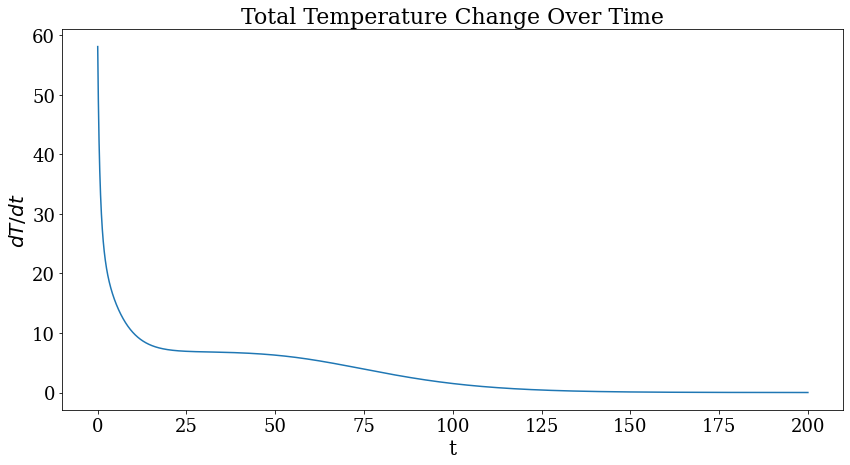

In [12]:
plt.figure(figsize=(14,7))
plt.plot(t, dTdt_array)
plt.title("Total Temperature Change Over Time", fontsize=22)
plt.xlabel("t", fontsize=20)
plt.ylabel(r"$ dT/dt $", fontsize=20)
plt.show()

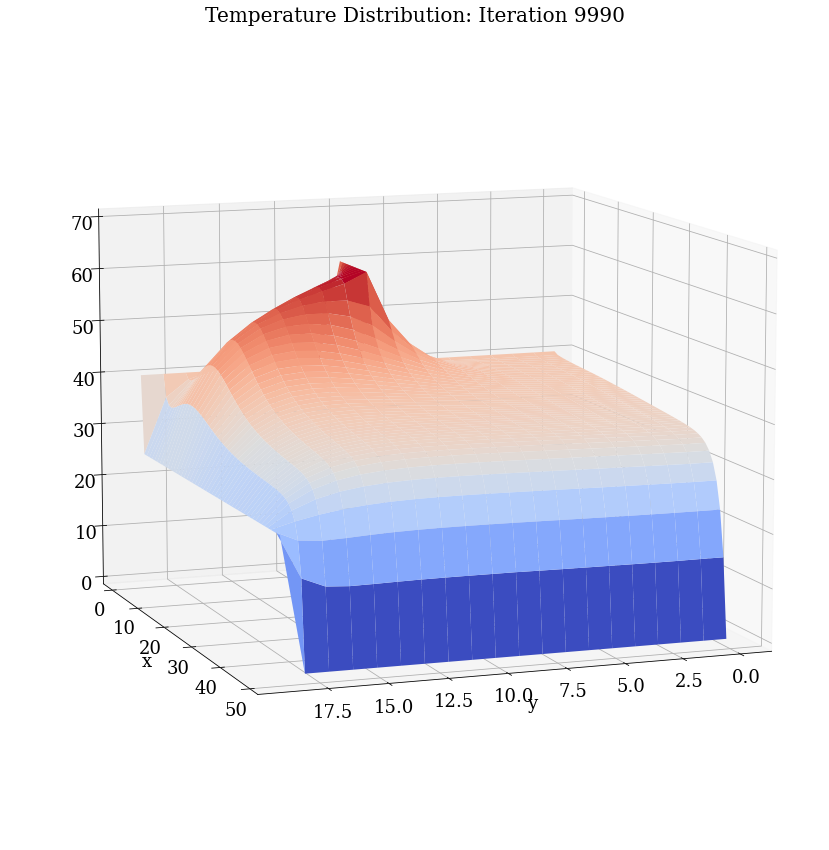

In [14]:
for j in range(Nt):
    if (j % 10) == 0:
        fig = plt.figure(figsize=(16,15))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(X, Y, U_T[j], cmap=cm.coolwarm, linewidth=0.5)#, antialiased=False)
        ax.view_init(10,70)
        plt.title("Temperature Distribution: Iteration {}".format(j), fontsize=20)
        plt.xlabel("y", fontsize=18)
        plt.ylabel("x", fontsize=18)
        ax.set_zlim([0,70])
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()